In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
curr_dir = os.getcwd()
dir_path = os.path.join(curr_dir , 'drive' , 'MyDrive','Codalab','Meme Classification Challenge','Tamil_troll_memes')
os.listdir(dir_path)

['training_img.zip', 'train_captions.csv', 'training_img']

In [ ]:
img_dir = os.path.join(dir_path , 'training_img','uploaded_tamil_memes')
print(f" No. of training images => {len(os.listdir(img_dir)) } ")

 No. of training images => 2300 


In [ ]:
import pandas as pd
df_path = os.path.join(dir_path,'train_captions.csv')
df = pd.read_csv(df_path)
df.sample(10)

,Unnamed: 0,imagename,captions
2089,2139,troll_253.jpg,This may happen in your future unta pazhaya Fa...
1304,1304,troll_1255.jpg,VARADHACHANAILAM VENDAM SIR PONNU KATTUNA SELA...
2012,2062,troll_194.jpg,kevalam sunday la vekura kari konzhambu kaga l...
1727,1777,troll_1683.png,FM NA RADIO CITY ARIVU KETTA MUNDAM FM NA F...
1181,1181,troll_1144.jpg,PEOPLE : EARKANAVAE INDHA COIN SELLATHUNU EVAN...
238,238,Not_troll_297.jpg,"yerumamadu maadhiri valandhiruppan aaana, innu..."
205,205,Not_troll_267.jpg,shshabha... thanga mudiyala..
1252,1252,troll_1208.png,peeda
1112,1112,troll_1082.jpg,i hate my life... ~me: apro neeyalam ena p**...
940,940,Not_troll_929.jpg,yeppa paru yennaiyave vambiluthukittu goiyale...


In [ ]:
def modify_tags(text):
    arr = text.rsplit('_',1)
    return arr[0]

In [ ]:
df.columns

Index(['Unnamed: 0', 'imagename', 'captions'], dtype='object')

In [ ]:
df.drop(['Unnamed: 0'] , axis = 1 , inplace = True)

In [ ]:
df['labels'] = df['imagename'].apply(modify_tags)

In [ ]:
df.sample(5)

,imagename,captions,labels
1940,troll_1875.jpg,DARBAR 1ST HALF *FANS : HUMOURS INTERESTING IN...,troll
319,Not_troll_37.jpg,yenna feelinga?? illa feelinganu kekkuren...,Not_troll
1932,troll_1868.jpg,WHEN MY FFRIENDS RECORDED VOICE COMES WHILE LI...,troll
1902,troll_1840.jpg,no comments,troll
53,Not_troll_13.jpg,yethanai nadurathiriel naan vitukku pogumpodhu...,Not_troll


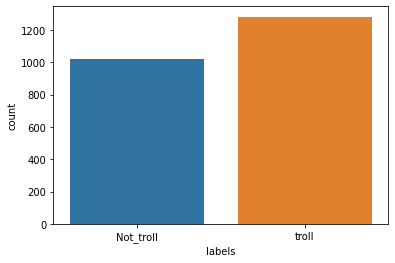

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = df['labels'])

In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dropout , Dense, Input, concatenate , GlobalAveragePooling2D , AveragePooling2D , Flatten  
from tensorflow.keras.optimizers import RMSprop , Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

In [ ]:
model.compile(loss = 'binary_crossentropy' , optimizer= 'adam' , metrics = ['acc'])

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

IMG_SHAPE = (256,256)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
                                          dataframe = df,
                                          directory = img_dir,
                                          x_col = "imagename",
                                          y_col = "labels",
                                          subset = "training",
                                          batch_size = 64,
                                          seed = 42,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = IMG_SHAPE
                          )

valid_generator = datagen.flow_from_dataframe(
                                          dataframe = df,
                                          directory = img_dir,
                                          x_col = "imagename",
                                          y_col = "labels",
                                          subset = "validation",
                                          batch_size = 64,
                                          seed = 42,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = IMG_SHAPE
                          )


Found 1725 validated image filenames belonging to 2 classes.
Found 575 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
STEP_SIZE_TRAIN

26

In [ ]:
STEP_SIZE_VALID

8

In [ ]:
import time
file_path = './drive/MyDrive/Meme Classification Challenge/Models/pretrained_inception_model .{epoch:02d}-{val_loss:.2f}s '
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=file_path + str(time.asctime()) + '.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
history = model.fit( train_generator,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_data=valid_generator,
                     validation_steps=STEP_SIZE_VALID,
                     epochs=10,
                     callbacks = [my_callbacks]
                    )

Epoch 1/10
 1/26 [>.............................] - ETA: 0s - loss: 0.6979 - acc: 0.6250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 671s 26s/step - loss: 0.5468 - acc: 0.7863 - val_loss: 0.9689 - val_acc: 0.5234
Epoch 2/10
26/26 [==============================] - 17s 649ms/step - loss: 0.2867 - acc: 0.8826 - val_loss: 0.3179 - val_acc: 0.8730
Epoch 3/10
26/26 [==============================] - 17s 651ms/step - loss: 0.2293 - acc: 0.9193 - val_loss: 0.4804 - val_acc: 0.8047
Epoch 4/10
26/26 [==============================] - 17s 649ms/step - loss: 0.1774 - acc: 0.9410 - val_loss: 0.7295 - val_acc: 0.7109


In [ ]:
import time
t = time.asctime()
model.save('./drive/MyDrive/Codalab/Meme Classification Challenge/Models/Pretrained_Inception_Model '+str(t))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/MyDrive/Codalab/Meme Classification Challenge/Models/Pretrained_Inception_Model Tue Dec 15 11:43:43 2020/assets


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)
plt.rcParams['figure.figsize'] = [14,10]
plt.rcParams['axes.facecolor'] = 'white'

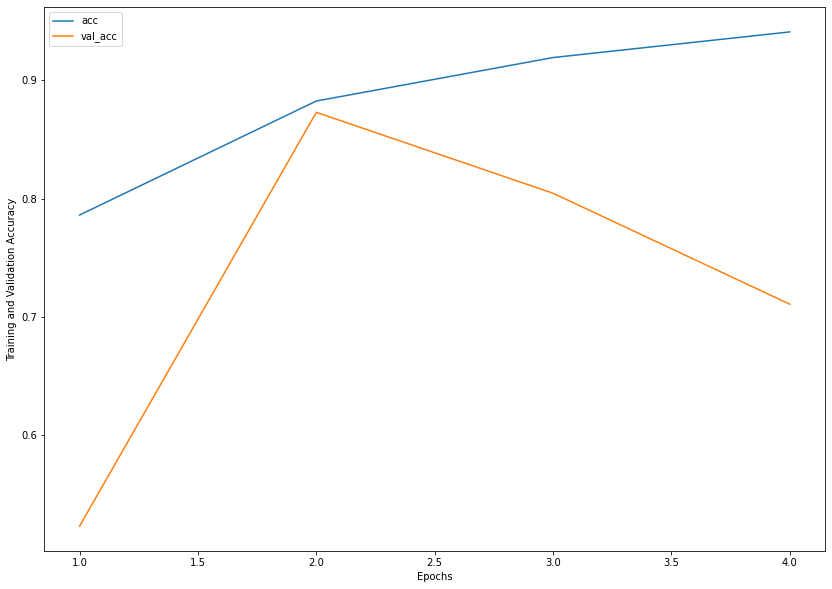

In [ ]:

plt.plot(epochs , acc)
plt.plot(epochs , val_acc)
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(['acc' , 'val_acc'])

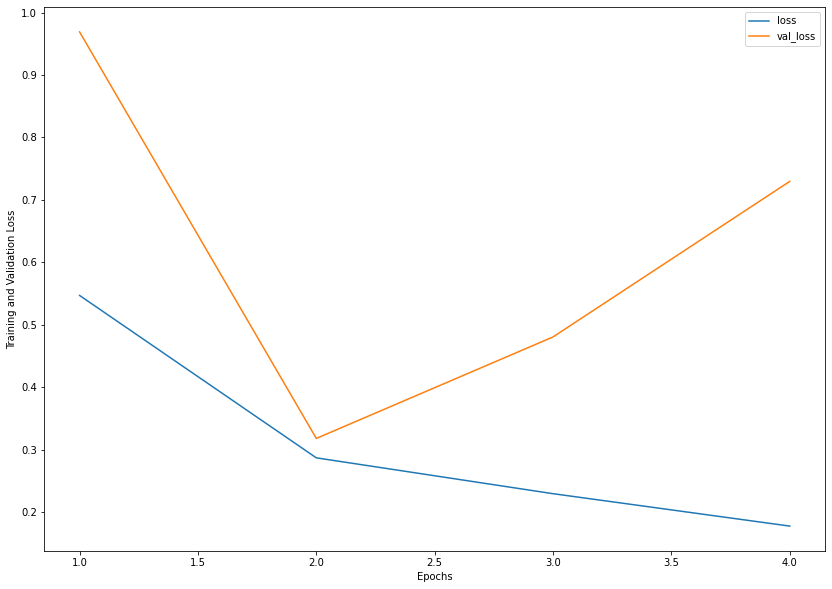

In [ ]:
plt.plot(epochs , loss)
plt.plot(epochs , val_loss)
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend(['loss','val_loss'])